# Detect Animal and UrbanSound

## Packages and Parameters

In [1]:
import os
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = r"~/data"

# melspectrogram
SAMPLE_RATE = 44100
SAMPLE_RATE = 44100
MAX_DURATION = 5
N_MELS = 32
N_FFT = 256
HOP_LENGTH = 64
N_CLASSES = 2

CLASS_MAPPING = {
    "Animals": 0,
    "urban noises": 1
}

## Feature extraction and Load data

In [2]:
# Melspectrogram
def extract_melspectrogram(file_path, augment=False):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        if augment:
            if np.random.random() < 0.3:
                audio += np.random.normal(0, 0.005, audio.shape)
            if np.random.random() < 0.3:
                shift = int(np.random.uniform(-0.2, 0.2) * len(audio))
                audio = np.roll(audio, shift)
            if np.random.random() < 0.3:
                audio *= np.random.uniform(0.8, 1.2)

        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-8)
        mel_mean = np.mean(mel_spec_db, axis=1)
        mel_std = np.std(mel_spec_db, axis=1)
        return np.concatenate([mel_mean, mel_std])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# File List
def get_file_list(data_dir, CLASS_MAPPING):
    file_list = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir) or class_name not in CLASS_MAPPING:
            continue
        label = CLASS_MAPPING[class_name]
        for fname in os.listdir(class_dir):
            if fname.endswith('.wav'):
                fpath = os.path.join(class_dir, fname)
                file_list.append((fpath, label))
    return file_list

## Split Train(augmentation) and Test Data

In [3]:
# Split Files
file_list = get_file_list(BASE_PATH, CLASS_MAPPING)
file_paths, labels = zip(*file_list)
X_train_f, X_test_f, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# augmentation
def extract_features_with_augmentation(file_paths, labels, augment_times=2):
    X = []
    y = []
    for fpath, label in zip(file_paths, labels):
        # original
        feature = extract_melspectrogram(fpath, augment=False)
        if feature is not None:
            X.append(feature)
            y.append(label)
        # augment
        for _ in range(augment_times):
            aug_feature = extract_melspectrogram(fpath, augment=True)
            if aug_feature is not None:
                X.append(aug_feature)
                y.append(label)
    return np.array(X), np.array(y)

# Extract Train / Test
X_train, y_train = extract_features_with_augmentation(X_train_f, y_train, augment_times=2)
X_test = np.array([extract_melspectrogram(f, augment=False) for f in X_test_f])
y_test = np.array(y_test)

## Model 

In [4]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc_model.fit(X_train, y_train)
y_pred = rfc_model.predict(X_test)

## Model's Score

In [6]:
# cross_val
k_fold_result = cross_val_score(rfc_model, X_train, y_train, cv=6)
# test_acc = rfc_model.score(X_test, y_test)
# print("accuracy_score:\n",test_acc)
print("k_fold_result:\n",k_fold_result,"\n")
print("mean of k_fold_result:\n",k_fold_result.mean(),"\n")


# F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

k_fold_result:
 [0.83984375 0.8359375  0.87109375 0.87109375 0.83984375 0.859375  ] 

mean of k_fold_result:
 0.8528645833333334 

Accuracy: 0.8672
Precision: 0.8725
Recall: 0.8672
F1-Score: 0.8653


## Confusion Matrix

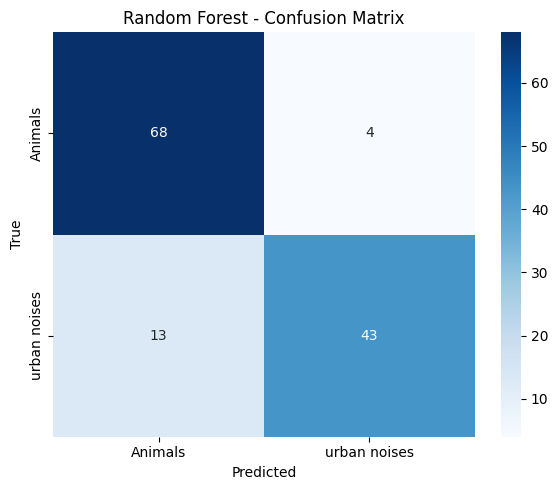

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_MAPPING.keys(), yticklabels=CLASS_MAPPING.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig('random_forest_confusion_matrix.png', dpi=300)
plt.show()
plt.show()